# EDA for the February TPS

The present EDA **explains the structures in the competition's dataset and derives ideas for modeling and for creating a classifier.**

In particular, it explains:
- Why the feature values are discrete and what we can do with this information
- How error rates are determined
- How the test data deviate from the training data and what this means

At the end, a possible approach for solving the classification problem is proposed.

Some information in this EDA comes from the paper ["Analysis of Identification Method for Bacterial Species and Antibiotic Resistance Genes Using Optical Data From DNA Oligomers"](https://www.frontiersin.org/articles/10.3389/fmicb.2020.00257/full).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from math import factorial

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans


We start by reading the data and converting the bacteria names to numbers:

In [2]:
train_df = pd.read_csv('../input/tabular-playground-series-feb-2022/train.csv')
test_df = pd.read_csv('../input/tabular-playground-series-feb-2022/test.csv')

elements = [e for e in train_df.columns if e != 'row_id' and e != 'target']

# Convert the 10 bacteria names to the integers 0 .. 9
le = LabelEncoder()
train_df['target_num'] = le.fit_transform(train_df.target)

train_df.shape, test_df.shape

((200000, 289), (100000, 287))

I'll skip the paragraphs about missing values (there are none) and about class balance (the ten classes are balanced) and immediately jump into the interesting analysis.

# Discreteness of the values

Let's look at the unique values of an arbitrary feature. We notice:
1. Although the feature is a floating point number, there are not 200000 unique values, but only about one hundred.
2. The last few digits are always the same (they always end with 0846558 from 1.00846558e-05 through 9.70846558e-05).


In [3]:
np.unique(train_df.A0T0G2C8)

array([-4.29153442e-05, -4.19153442e-05, -4.09153442e-05, -3.99153442e-05,
       -3.89153442e-05, -3.79153442e-05, -3.69153442e-05, -3.59153442e-05,
       -3.49153442e-05, -3.39153442e-05, -3.29153442e-05, -3.19153442e-05,
       -3.09153442e-05, -2.99153442e-05, -2.89153442e-05, -2.79153442e-05,
       -2.69153442e-05, -2.59153442e-05, -2.49153442e-05, -2.39153442e-05,
       -2.29153442e-05, -2.19153442e-05, -2.09153442e-05, -1.99153442e-05,
       -1.89153442e-05, -1.79153442e-05, -1.69153442e-05, -1.59153442e-05,
       -1.49153442e-05, -1.39153442e-05, -1.29153442e-05, -1.19153442e-05,
       -1.09153442e-05, -9.91534424e-06, -8.91534424e-06, -7.91534424e-06,
       -6.91534424e-06, -5.91534424e-06, -4.91534424e-06, -3.91534424e-06,
       -2.91534424e-06, -1.91534424e-06, -9.15344238e-07,  8.46557617e-08,
        1.08465576e-06,  2.08465576e-06,  3.08465576e-06,  4.08465576e-06,
        5.08465576e-06,  6.08465576e-06,  7.08465576e-06,  8.08465576e-06,
        9.08465576e-06,  

This observation strongly suggests that these values originally were integers. These integers were divided by 1000000 and a constant was subtracted.

The [paper](https://www.frontiersin.org/articles/10.3389/fmicb.2020.00257/full) describes this process and gives the formula for the additive constant, which they call *bias*. With the help of this formula, we can convert the floating point numbers back to the original integers:

In [4]:
def bias(w, x, y, z):
    return factorial(10) / (factorial(w) * factorial(x) * factorial(y) * factorial(z) * 4**10)

def bias_of(s):
    w = int(s[1:s.index('T')])
    x = int(s[s.index('T')+1:s.index('G')])
    y = int(s[s.index('G')+1:s.index('C')])
    z = int(s[s.index('C')+1:])
    return factorial(10) / (factorial(w) * factorial(x) * factorial(y) * factorial(z) * 4**10)

train_i = pd.DataFrame({col: ((train_df[col] + bias_of(col)) * 1000000).round().astype(int)
                        for col in elements})
test_i = pd.DataFrame({col: ((test_df[col] + bias_of(col)) * 1000000).round().astype(int)
                       for col in elements})
train_i

,A0T0G0C10,A0T0G1C9,A0T0G2C8,A0T0G3C7,A0T0G4C6,A0T0G5C5,A0T0G6C4,A0T0G7C3,A0T0G8C2,A0T0G9C1,...,A8T0G0C2,A8T0G1C1,A8T0G2C0,A8T1G0C1,A8T1G1C0,A8T2G0C0,A9T0G0C1,A9T0G1C0,A9T1G0C0,A10T0G0C0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1000,0,1000,0,0,0,0,...,0,0,0,1000,1000,0,0,0,0,0
2,0,8,50,243,468,510,443,239,44,3,...,85,170,91,167,192,115,20,18,29,2
3,1,4,55,359,692,762,596,311,40,3,...,111,237,143,266,288,196,31,25,56,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,0,10,40,290,550,530,400,320,20,0,...,60,210,100,190,230,70,10,70,30,0
199996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1000,1000,0,0,0,0,0
199997,1,11,38,83,181,203,163,99,38,2,...,71,201,174,196,299,137,26,45,31,1
199998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2000,0,0,0,0,0,0


The integers sum up to one million in every row:

In [5]:
train_i.sum(axis=1).min(), train_i.sum(axis=1).max()

(1000000, 1000000)

Did you notice that in some rows all entries are multiples of 10 or of 1000? We'll verify this systematically by computing the greatest common divisor (gcd) for every row:

In [6]:
# def gcd_of_all(df_i):
#     gcd = df_i[elements[0]]
#     for col in elements[1:]:
#         gcd = np.gcd(gcd, df_i[col])
#     return gcd

train_df['gcd'] = np.gcd.reduce(train_i[elements], axis=1)
test_df['gcd'] = np.gcd.reduce(test_i[elements], axis=1)
# train_df['gcd'] = train_i[elements].apply(np.gcd.reduce, axis=1) # slow
# test_df['gcd'] = test_i[elements].apply(np.gcd.reduce, axis=1)
# train_df['gcd'] = gcd_of_all(train_i)
# test_df['gcd'] = gcd_of_all(test_i)
np.unique(train_df['gcd'], return_counts=True), np.unique(test_df['gcd'], return_counts=True)

((array([    1,    10,  1000, 10000]), array([49969, 50002, 50058, 49971])),
 (array([    1,    10,  1000, 10000]), array([25208, 24951, 24930, 24911])))

We see that there are four gcd values (1, 10, 1000 and 10000) with equal frequencies. Connecting this result with what they write in the paper, we understand this part of the experiment:

For every row, they take the DNA of a bacterium and cut it into [decamers](https://en.wikipedia.org/wiki/K-mer) (DNA substrings of length 10). Then they put 1000000, 100000, 1000 or 100 decamers into their machine, and the machine counts how many times every of the 286 types from A0T0G0C10 to A10T0G0C0 occurs. This is what they call the spectrum (one could as well call it a histogram with 286 bins). They normalize the spectrum by dividing all counts by the row sum and subtracting the bias.

Every bacterium has its own characteristic spectrum, and the competition task is predicting the bacterium's name from the spectrum of a sample. If the sample spectrum is made from a million decamers, we'll have accurate estimates of the true frequencies and predicting the name will be easy; if the spectrum is made from only 100 decamers, we have little information and the prediction will be hard (the classes overlap). We can see the influence of the number of decamers in the following four PCA plots:

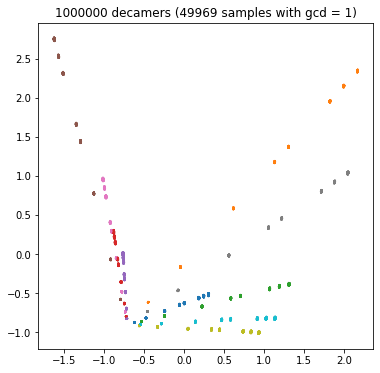

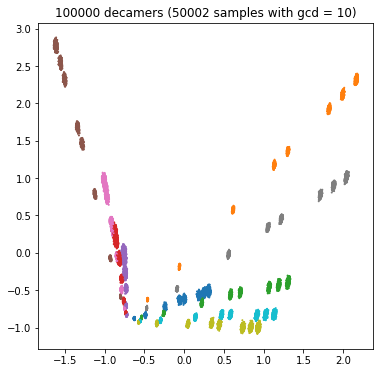

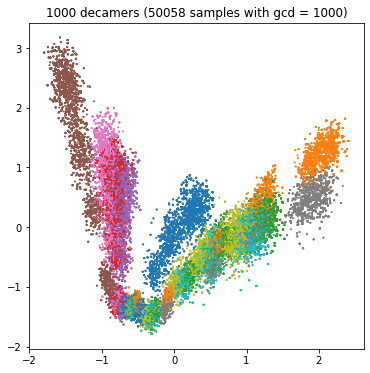

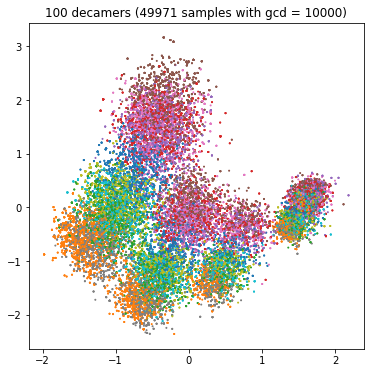

In [7]:
for scale in np.sort(train_df['gcd'].unique()):
    # Compute the PCA
    pca = PCA(whiten=True, random_state=1)
    pca.fit(train_i[elements][train_df['gcd'] == scale])

    # Transform the data so that the components can be analyzed
    Xt_tr = pca.transform(train_i[elements][train_df['gcd'] == scale])
    Xt_te = pca.transform(test_i[elements][test_df['gcd'] == scale])

    # Plot a scattergram, projected to two PCA components, colored by classification target
    plt.figure(figsize=(6,6))
    plt.scatter(Xt_tr[:,0], Xt_tr[:,1], c=train_df.target_num[train_df['gcd'] == scale], cmap='tab10', s=1)
    plt.title(f"{1000000 // scale} decamers ({(train_df['gcd'] == scale).sum()} samples with gcd = {scale})")
    plt.show()

**Insight:**
- We may want to create four separate classifiers for the four GCD values. For GCD = 1, we expect high accuracy; for GCD = 10000, accuracy will be lower.
- If we create only a single classifier, the gcd can be used as an additional feature.

# Duplicates

A third of the data are duplicates (thanks to @[teckmengwong](https://www.kaggle.com/teckmengwong) for [pointing this out](https://www.kaggle.com/c/tabular-playground-series-feb-2022/discussion/305364)):

In [8]:
train_df[elements].duplicated().sum(), test_df[elements].duplicated().sum()

(76007, 26779)

Counting the duplicates for the four GCD values separately, we see that most duplicates occur for the high GCD values. This can be explained: If every observation consists of 100 decamers in 286 bins, we should expect more duplicates than if 1000000 decamers are put in 286 bins.

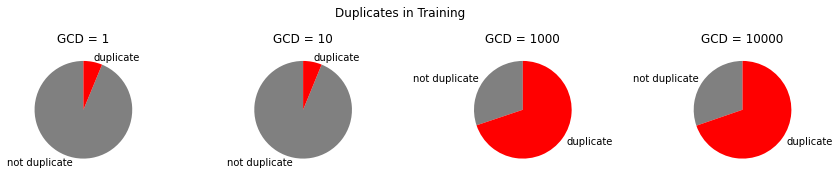

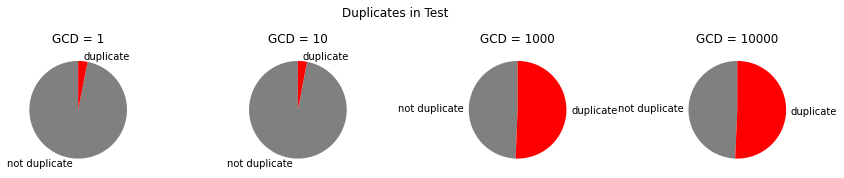

In [9]:
def plot_duplicates_per_gcd(df, title):
    plt.figure(figsize=(14, 3))
    plt.tight_layout()
    for i, gcd in enumerate(np.unique(df.gcd)):
        plt.subplot(1, 4, i+1)
        duplicates = df[df.gcd == gcd][elements].duplicated().sum()
        non_duplicates = len(df[df.gcd == gcd]) - duplicates
        plt.pie([non_duplicates, duplicates],
                labels=['not duplicate', 'duplicate'],
                colors=['gray', 'r'],
                startangle=90)
        plt.title(f"GCD = {gcd}")
    plt.subplots_adjust(wspace=0.8)
    plt.suptitle(title)
    plt.show()
        
plot_duplicates_per_gcd(train_df, title="Duplicates in Training")
plot_duplicates_per_gcd(test_df, title="Duplicates in Test")


**Insight:**
- We can reduce training and inference time by dropping the duplicates (and adjusting the sample weights).
- If we don't drop the duplicates, we must ensure that they don't inflate the cv scores. If the validation fold contains duplicates of a training fold's values, cv scores will be too high.
- There seems to be a fundamental difference between the low gcds (which have few duplicates) and the high gcds (which have many duplicates). 

# Understanding the simulated errors

Now we plot two arbitrary features at the highest precision (1000000 decamers). We see that the points of every class are grouped into eight clusters, the eight clusters lie on a straight line, and all these straight lines intersect in the origin:

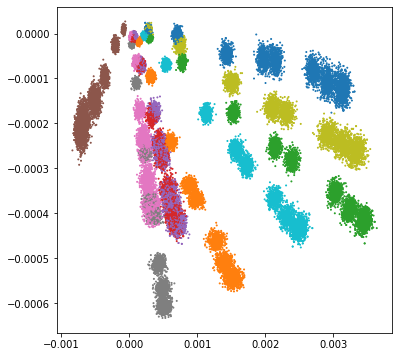

In [10]:
plt.figure(figsize=(6,6))
plt.scatter(train_df.iloc[:,240][train_df['gcd'] == 1],
            train_df.iloc[:,181][train_df['gcd'] == 1],
            c=train_df.target_num[train_df['gcd'] == 1],
            cmap='tab10', s=1)
plt.show()


Again, this is explained in the paper: Although every bacterium has its characteristic spectrum, the experiment produces a lot of noise. They model this noise by replacing a part of the bacterium's decamers by random decamers, and this amounts to a scaling of the spectrum towards the origin. 

The original clusters (far away from the origin) do not overlap, and classification is easy. With higher error rates, the clusters get nearer to the origin and start to overlap. Of course: higher error rates make classification more difficult.

The following histograms show that there are eight scalings (corresponding to eight error rates), and that the scalings are the same for all ten bacteria. We can read the eight values out of the histograms or determine them by a one-dimensional k-means clustering. The seven scaled-down clusters have size 550 and no duplicates within them; the unscaled cluster has size 1100 (of which 800 are unique and 300 are duplicates).

Bacteroides_fragilis
Cluster centers: [0.1, 0.24, 0.46, 0.64, 0.7, 0.88, 0.94, 1.0]
Cluster sizes: [ 556  576  559  557  568  528  585 1145]
Cluster unique elements: [556 576 559 557 568 528 585 824]

Campylobacter_jejuni
Cluster centers: [0.09, 0.23, 0.46, 0.64, 0.7, 0.88, 0.94, 1.0]
Cluster sizes: [ 550  542  538  578  566  560  565 1083]
Cluster unique elements: [550 542 538 578 566 560 565 789]

Enterococcus_hirae
Cluster centers: [0.09, 0.23, 0.46, 0.64, 0.7, 0.88, 0.94, 1.0]
Cluster sizes: [ 534  542  565  533  556  560  555 1111]
Cluster unique elements: [534 542 565 533 556 560 555 804]

Escherichia_coli
Cluster centers: [0.11, 0.24, 0.46, 0.64, 0.7, 0.88, 0.94, 1.0]
Cluster sizes: [ 552  524  538  545  549  540  553 1095]
Cluster unique elements: [552 524 538 545 549 540 553 796]

Escherichia_fergusonii
Cluster centers: [0.11, 0.24, 0.46, 0.64, 0.7, 0.88, 0.94, 1.0]
Cluster sizes: [ 547  559  543  542  553  545  566 1127]
Cluster unique elements: [547 559 543 542 553 545 566 7

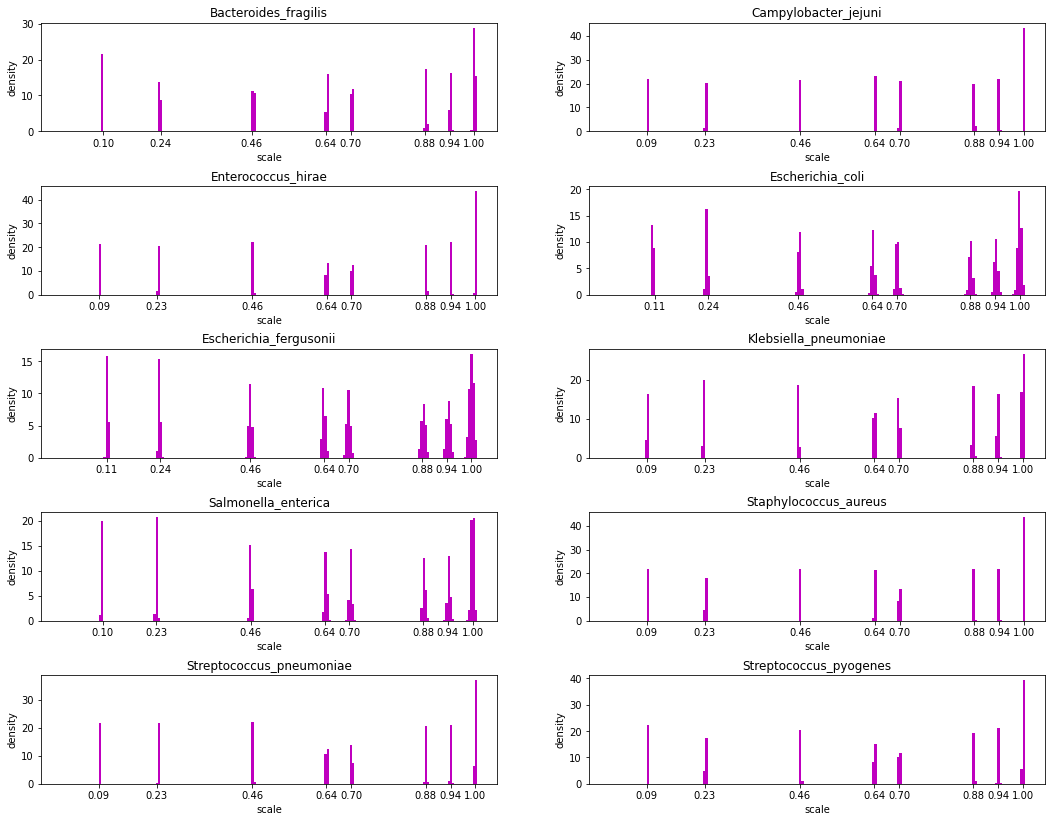

In [11]:
# Show how the spectra are scaled
# The original spectrum gives a peak at 1.0;
# the seven error rates give seven other peaks in the histograms
# The eight peaks in the histograms correspond to the eight clusters 
# in the scattergram above
v = train_df[elements].abs().sum(axis=1)
chosen_gcd = 1

plt.figure(figsize=(18, 14))
plt.tight_layout()
for t in range(10): # loop over the ten bacteria species
    plt.subplot(5, 2, t+1)
    plt.title(le.inverse_transform([t])[0])
    
    # Select a single GCD and a single species
    vt = v[(train_df['gcd'] == chosen_gcd) & (train_df['target_num'] == t)]
    
    # Do a one-dimensional clustering to get the cluster centers and the cluster sizes
    km = KMeans(n_clusters=8)
    km.fit(vt.values.reshape(-1, 1))
    cluster_max = km.cluster_centers_.max() # label this cluster with 1.0 (no simulated errors)
    print(le.inverse_transform(np.array([t]))[0])
    print('Cluster centers:', sorted((km.cluster_centers_ / cluster_max).ravel().round(2)))
    print('Cluster sizes:', np.unique(km.predict(vt.values.reshape(-1, 1)), return_counts=True)[1][np.argsort(km.cluster_centers_.ravel())])
    print('Cluster unique elements:', 
          train_df[elements][(train_df['gcd'] == chosen_gcd) & (train_df['target_num'] == t)].
          groupby(km.predict(vt.values.reshape(-1, 1))).apply(lambda df: np.unique(df.values, axis=0).shape[0]).
          values[np.argsort(km.cluster_centers_.ravel())])
    print()
    
    # Plot a histogram of the eight clusters
    plt.hist(vt / cluster_max, bins=np.linspace(0, (vt / cluster_max).max(), 200),
             color='m', density=True)
    plt.xticks(ticks=(km.cluster_centers_ / cluster_max).round(2))
    plt.xlabel('scale')
    plt.ylabel('density')
    #plt.ylim(0, 1100)
plt.subplots_adjust(hspace=0.5)
plt.show()

**Insight:**
- It should be possible to create a model which has 286 parameters per bacterium. These parameters should suffice to classify all samples. To fit these parameters, it may be useful to give the samples farther away from the origin a higher sample weight.
- Something is strange with the duplicates. These duplicates need further investigation.

# Comparing train and test

We can plot training and test data in the same diagram. There is a small deviation. This was announced in the paper: We train the classifier with some bacteria DNA, but the bacteria in the test set will have undergone mutation and have slightly different DNA.

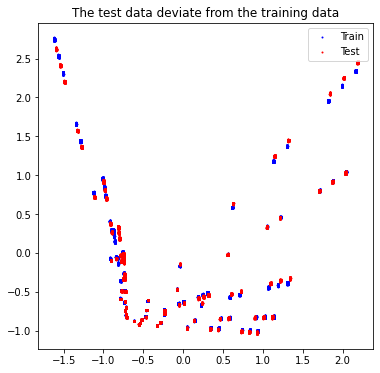

In [12]:
scale = 1

# Compute the PCA
pca = PCA(whiten=True, random_state=1)
pca.fit(train_i[elements][train_df['gcd'] == scale])

# Transform the data so that the components can be analyzed
Xt_tr = pca.transform(train_i[elements][train_df['gcd'] == scale])
Xt_te = pca.transform(test_i[elements][test_df['gcd'] == scale])

# Plot a scattergram, projected to two PCA components, of training and test data
plt.figure(figsize=(6,6))
plt.scatter(Xt_tr[:,0], Xt_tr[:,1], c='b', s=1, label='Train')
plt.scatter(Xt_te[:,0], Xt_te[:,1], c='r', s=1, label='Test')
plt.title("The test data deviate from the training data")
plt.legend()
plt.show()


Every dot in the diagram represents a cluster of 500 observations.

**Insight:**
- Training a classifier on the training data isn't enough. For really accurate results, we will somehow need to model the deviation between training and test data.
- We have to think about our cross-validation strategy: What sense does it make to cross-validate if the validation data are distributed differently from the test data?
- Maybe we can artificially generate data with the test distribution by fitting the spectra of the test bacteria and then using a [numpy.random.Generator.multinomial](https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.multinomial.html) to augment the data.
- Or perhaps pseudo-labeling or another semi-supervised method will serve as magic trick.

# Modeling approach

The data we have seen suggest that gradient boosting is not necessarily the optimal method for the task at hand. Maybe it is better to fit the characteristic spectrum for every bacterium and then try a maximum likelihood classification.

The cross-validation strategy will have to take the drift of the test distribution into account.

The gcd can be used as a feature, or we can create four separate classifiers based on gcd.

Another approach could be to use a [numpy.random.Generator.multinomial](https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.multinomial.html) to augment the data.